# Deep Learning and Image Recognition

## Keras Functional API and Merge Networks

For complex models the functional API can do all sorts of things that just aren’t possible with the Sequential model.  Models with multiple inputs and outputs, models with shared layers – once you start designing architectures that need these things, you will have to use the functional API to build your model.

Reference: https://www.puzzlr.org/the-keras-functional-api-five-simple-examples/

In [1]:
from keras.models import Input, Model
from keras.layers import Dense, Dropout, concatenate

Using TensorFlow backend.


### Generate Data

In [2]:
import numpy as np
 
n_row = 1000
x1 = np.random.randn(n_row)
x2 = np.random.randn(n_row)
x3 = np.random.randn(n_row)
y_classifier = np.array([1 if (x1[i] + x2[i] + (x3[i])/3 + np.random.randn(1) > 1) else 0 for i in range(n_row)])
y_cts = x1 + x2 + x3/3 + np.random.randn(n_row)
dat = np.array([x1, x2, x3]).transpose()

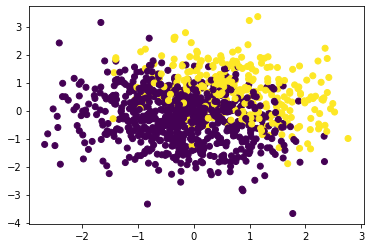

In [3]:
# Take a look at the data
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(dat[:,0],dat[:,1], c=y_classifier)
plt.show()

In [4]:
# Generate indexes of test and train 
idx_list = np.linspace(0,999,num=1000)
idx_test = np.random.choice(n_row, size = 200, replace=False)
idx_train = np.delete(idx_list, idx_test).astype('int')
 
# Split data into test and train
dat_train = dat[idx_train,:]
dat_test = dat[idx_test,:]
y_classifier_train = y_classifier[idx_train]
y_classifier_test = y_classifier[idx_test]
y_cts_train = y_cts[idx_train]
y_cts_test = y_cts[idx_test]

### Logistic Model

Build logistic regression using the Keras functional model. It’s quite easy and straightforward once you know some key frustration points:

The input layer needs to have shape (p,) where p is the number of columns in your training matrix. In our case we have three columns (x_1, x_2, x_3) so we set the shape to (3,)

The output layer needs to have the same number of dimensions as the number of neurons in the dense layer. In our case we’re predicting a binary vector (0 or 1), which has 1 dimension, so our dense layer needs to have one neuron.

In [5]:
# Build the model with Functional API
inputs = Input(shape=(3,))
output = Dense(1, activation='sigmoid')(inputs)
logistic_model = Model(inputs, output)
 
# Compile the model 
logistic_model.compile(optimizer='sgd',
                       loss = 'binary_crossentropy',
                       metrics=['accuracy'])

In [6]:
logistic_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Fit on training data
logistic_model.fit(x=dat_train, y=y_classifier_train, epochs = 500, verbose=0,
                   validation_data = (dat_test, y_classifier_test))
logistic_model.fit(x=dat_train, y=y_classifier_train, epochs = 1, verbose=1,
                   validation_data = (dat_test, y_classifier_test))

Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 0s 69us/step - loss: 0.3276 - accuracy: 0.8600 - val_loss: 0.3316 - val_accuracy: 0.8400


### Deep Model

Below we train a neural network with a large number of hidden layers. We also add Dropout to the layers to reduce overfitting.

It can be useful sometimes to use for loops and if statements when using the Functional API, particularly for complicated models.

This model does about as well as the previous neural network. It could probably do better by tuning the hyperparameters, like the amount of dropout or the number of neural network layers.

In [8]:
# specify how many hidden layers to add (min 1)
n_layers = 5
 
inputs = Input(shape=(3,))
x = Dense(200, activation='relu')(inputs)
x = Dropout(0.4)(x)
for layer in range(n_layers - 1):
    x = Dense(200, activation='relu')(x)
    x = Dropout(0.3)(x)

output = Dense(1, activation='sigmoid')(x)
deep_n_net = Model(inputs, output)
 
deep_n_net.compile(optimizer = 'adam', loss= 'binary_crossentropy', metrics=['accuracy'])
 
deep_n_net.fit(dat_train, y_classifier_train, epochs = 50, verbose=0,
validation_data = (dat_test, y_classifier_test))
deep_n_net.fit(dat_train, y_classifier_train, epochs = 1, verbose=1,
validation_data = (dat_test, y_classifier_test))

Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 0s 218us/step - loss: 0.3187 - accuracy: 0.8612 - val_loss: 0.3352 - val_accuracy: 0.8600


In [9]:
deep_n_net.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               800       
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0   

### Simple Neural Network + Metadata

One use case for the Functional API is where you have multiple data sources that you want to pull together into one model.

For example, if your task is image classification you could use the Sequential model to build a convolutional neural network that would run over the images. If you decide to use the Functional API instead of the Sequential model, you can also include metadata of your image into your model: perhaps its size, date created, or its tagged location.

#### Add Metadata

In [10]:
metadata_1 = y_classifier + np.random.gumbel(scale = 0.6, size = n_row)
metadata_2 = y_classifier - np.random.laplace(scale = 0.5, size = n_row)
metadata = np.array([metadata_1,metadata_2]).T
 
# Create training and test set
metadata_train = metadata[idx_train,:]
metadata_test = metadata[idx_test,:]

### Merge Model

In [11]:
input_dat = Input(shape=(3,)) # for the three columns of dat_train
n_net_layer = Dense(50, activation='relu') # first dense layer
x1 = n_net_layer(input_dat)
x1 = Dropout(0.5)(x1)
 
input_metadata = Input(shape=(2,))
x2 = Dense(25, activation= 'relu')(input_metadata)
x2 = Dropout(0.3)(x2)
 
con = concatenate(inputs = [x1,x2] ) # merge in metadata
x3 = Dense(50)(con)
x3 = Dropout(0.3)(x3)
output = Dense(1, activation='sigmoid')(x3)
meta_n_net = Model(inputs=[input_dat, input_metadata], outputs=output)
 
meta_n_net.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

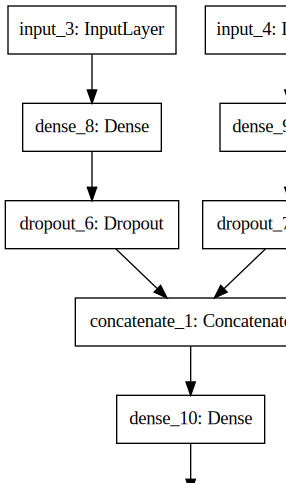

In [18]:
import keras, pydotplus
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
keras.utils.vis_utils.pydot = pydotplus

SVG(model_to_dot(meta_n_net).create(prog='dot', format='svg'))

In [19]:
meta_n_net.fit(x=[dat_train, metadata_train], y=y_classifier_train, epochs=50, verbose=0,
validation_data=([dat_test, metadata_test], y_classifier_test))
meta_n_net.fit(x=[dat_train, metadata_train], y=y_classifier_train, epochs=1, verbose=1,
validation_data=([dat_test, metadata_test], y_classifier_test))

Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 0s 91us/step - loss: 0.2079 - accuracy: 0.9187 - val_loss: 0.2091 - val_accuracy: 0.9200
